In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl.nn import GraphConv
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import networkx as nx
import pandas as pd
import dgl.nn as dglnn
import dgl.function as fn
import numpy as np
import matplotlib.pyplot as plt

# Read Data (数据读取)

In [64]:
# Load different graph files
out_flow_edges_df = pd.read_csv('edge_data/out_flow_edges.csv')
in_flow_edges_df = pd.read_csv('edge_data/in_flow_edges.csv')
proximity_edges_df = pd.read_csv('edge_data/proximity_edges.csv')
dcorr_edges_df = pd.read_csv('edge_data/dcorr_edges.csv')
pcorr_edges_df = pd.read_csv('edge_data/pcorr_edges.csv')
fcorr_edges_df = pd.read_csv('edge_data/fcorr_edges.csv')
delivery_df = pd.read_csv('edge_data/delivery.csv')

# Load Node Data (节点数据)
node = pd.read_csv('node_data/Node_feats5ring_standerdised.csv')
col_feat = node.columns[3:]
node[col_feat].head()

,count_work,count_live,count_shop,count_play,count_elem,pop_home,pop_work,lon,lat
0,-0.511907,-0.641922,-0.510910,-0.530859,-0.470742,-1.003943,-1.003943,0.006036,-2.140695
1,-0.539804,-0.641922,-0.585997,-0.652722,-0.470742,-1.007459,-1.007459,0.072030,-2.140695
2,-0.484010,-0.641922,-0.454596,-0.652722,-0.470742,-0.976132,-0.976132,0.138025,-2.140695
3,-0.539804,-0.641922,-0.585997,-0.652722,-0.470742,-1.091849,-1.091849,0.204019,-2.140695
4,-0.567701,-0.369151,-0.567225,-0.530859,-0.470742,-0.954715,-0.954715,-0.059958,-2.073320


In [65]:
# Filter out edges with low weight (过滤出流量大于 2 的边，作为稳定流量以预测)

out_flow_edges_df = out_flow_edges_df[out_flow_edges_df['weight'] > 2]
in_flow_edges_df = in_flow_edges_df[in_flow_edges_df['weight'] > 2]
Flow_df = out_flow_edges_df.copy()
Flow_df.head()

,src_id,dst_id,weight
172,8116,7910,7.0
178,8116,8116,16.0
179,8116,8117,13.0
186,8116,8528,8.0
187,8116,8529,8.0


# Initialize Heterogeneous Graph Data (初始化异质图数据)

## Map Node IDs to a Consecutive Range (节点 ID 映射为连续数组)

In [66]:
graph_data = {}

edge_types = {
    'in_flow': in_flow_edges_df,
    'out_flow': out_flow_edges_df,
    'proximity': proximity_edges_df,
    'dcorr': dcorr_edges_df,
    'pcorr': pcorr_edges_df,
    'fcorr': fcorr_edges_df,
}

# Construct the graph data by looping over edge types and their corresponding DataFrames
for edge_type, edges_df in edge_types.items():
    graph_data[('spatial_unit', edge_type, 'spatial_unit')] = (
        torch.tensor(edges_df['src_id'].values),
        torch.tensor(edges_df['dst_id'].values)
    )
graph_data

{('spatial_unit',
  'in_flow',
  'spatial_unit'): (tensor([ 8519,  8931,  8116,  ..., 18614, 18820, 18834]), tensor([ 9343,  9343,  8116,  ..., 18410, 18410, 18425])),
 ('spatial_unit',
  'out_flow',
  'spatial_unit'): (tensor([ 8116,  8116,  8116,  ..., 18410, 18410, 18410]), tensor([ 7910,  8116,  8117,  ..., 18408, 18614, 18820])),
 ('spatial_unit',
  'proximity',
  'spatial_unit'): (tensor([ 6873,  6873,  6873,  ..., 19035, 19035, 19036]), tensor([ 6874,  6875,  6876,  ..., 19036, 19037, 19037])),
 ('spatial_unit',
  'dcorr',
  'spatial_unit'): (tensor([ 8100,  8100,  8100,  ..., 18614, 18630, 18817]), tensor([ 8103,  8102,  8309,  ..., 18817, 18631, 18819])),
 ('spatial_unit',
  'pcorr',
  'spatial_unit'): (tensor([ 8100,  8100,  8100,  ..., 18614, 18630, 18817]), tensor([ 8103,  8102,  8309,  ..., 18817, 18631, 18819])),
 ('spatial_unit',
  'fcorr',
  'spatial_unit'): (tensor([ 7079,  7079,  7079,  ..., 17988, 17988, 18192]), tensor([ 7285,  7694,  7888,  ..., 18192, 18604, 18604

In [67]:
# Find all unique node IDs and map them to a consecutive range
unique_ids = set()
for (_, _, _), (src, dst) in graph_data.items():
    unique_ids.update(src.tolist())
    unique_ids.update(dst.tolist())

id_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_ids)}

# Save mapping to CSV
mapping_df = pd.DataFrame(list(id_mapping.items()), columns=['Original_ID', 'Mapped_ID'])
mapping_df.to_csv('mapping_df_5ring.csv', index=False)

# Update edges with new node IDs for consistency
edge_dfs = [out_flow_edges_df, in_flow_edges_df, proximity_edges_df, dcorr_edges_df, pcorr_edges_df, fcorr_edges_df]
for df in edge_dfs:
    df['src_id'] = df['src_id'].map(id_mapping)
    df['dst_id'] = df['dst_id'].map(id_mapping)

## Construct graph_data (根据映射ID后的异质边创建图数据)

In [68]:
for edge_type, edges_df in edge_types.items():
    graph_data[('spatial_unit', edge_type, 'spatial_unit')] = (
        torch.tensor(edges_df['src_id'].values),
        torch.tensor(edges_df['dst_id'].values)
    )
graph_data

{('spatial_unit',
  'in_flow',
  'spatial_unit'): (tensor([ 104,  280, 2742,  ...,  964, 1050, 1064]), tensor([ 460,  460, 2742,  ...,  875,  875,  890])),
 ('spatial_unit',
  'out_flow',
  'spatial_unit'): (tensor([2742, 2742, 2742,  ...,  875,  875,  875]), tensor([2659, 2742, 2743,  ...,  873,  964, 1050])),
 ('spatial_unit',
  'proximity',
  'spatial_unit'): (tensor([2302, 2302, 2302,  ..., 1137, 1137, 1138]), tensor([2303, 2304, 2305,  ..., 1138, 1139, 1139])),
 ('spatial_unit',
  'dcorr',
  'spatial_unit'): (tensor([2726, 2726, 2726,  ...,  964,  980, 1047]), tensor([2729, 2728,   13,  ..., 1047,  981, 1049])),
 ('spatial_unit',
  'pcorr',
  'spatial_unit'): (tensor([2726, 2726, 2726,  ...,  964,  980, 1047]), tensor([2729, 2728,   13,  ..., 1047,  981, 1049])),
 ('spatial_unit',
  'fcorr',
  'spatial_unit'): (tensor([2364, 2364, 2364,  ...,  686,  686,  774]), tensor([2429, 2567, 2637,  ...,  774,  954,  954]))}

## Generate Train, Validation, and Test Masks (生成训练、验证和测试掩码)

In [69]:
def generate_masks(num_edges, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
    """
    生成三个互不交叉的训练、验证和测试掩码数组。
    
    参数:
    - num_edges: 总的边数。
    - train_ratio: 训练集所占的比例。
    - val_ratio: 验证集所占的比例。
    - test_ratio: 测试集所占的比例。
    
    返回:
    - train_mask: 训练集的掩码。
    - val_mask: 验证集的掩码。
    - test_mask: 测试集的掩码。
    """
    if train_ratio + val_ratio + test_ratio != 1:
        raise ValueError("The sum of ratios must equal 1.")
    
    # 生成一个随机的索引数组
    indices = np.arange(num_edges)
    
    # 随机打乱索引数组，设置种子确保每次运行结果一样
    np.random.seed(42)
    np.random.shuffle(indices)
    
    # 计算每个子集的边界
    num_train = int(num_edges * train_ratio)
    num_val = int(num_edges * val_ratio)
    num_test = int(num_edges * test_ratio)
    
    # 生成掩码
    train_mask = np.zeros(num_edges, dtype=bool)
    val_mask = np.zeros(num_edges, dtype=bool)
    test_mask = np.zeros(num_edges, dtype=bool)
    
    train_mask[indices[:num_train]] = True
    val_mask[indices[num_train:num_train + num_val]] = True
    test_mask[indices[num_train + num_val:]] = True
    
    # 将掩码转换为PyTorch张量
    train_mask = torch.tensor(train_mask, dtype=torch.bool)
    val_mask = torch.tensor(val_mask, dtype=torch.bool)
    test_mask = torch.tensor(test_mask, dtype=torch.bool)
    
    return train_mask, val_mask, test_mask

## Construct the DGL Heterogeneous Graph (构建 DGL 异质图)

In [70]:
# Generate masks for edges
train_mask, val_mask, test_mask = generate_masks(len(out_flow_edges_df))

g = dgl.heterograph(graph_data)

# Add node features (添加节点特征)
feature_matrix = torch.tensor(node[col_feat].values, dtype=torch.float32)
 # Add lables: delivery and pick_up
delivery_tensor = torch.tensor(node['delivery_c'].values, dtype=torch.float32)
pick_tensor = torch.tensor(node['pick_count'].values, dtype=torch.float32)

g.nodes['spatial_unit'].data['feature'] = feature_matrix
g.nodes['spatial_unit'].data['delivery'] = delivery_tensor
g.nodes['spatial_unit'].data['pick_up'] = pick_tensor

# Standardize edge weights (模块化边权重)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for edge, df in edge_types.items():
    g.edges[edge].data['weight'] = torch.tensor(scaler.fit_transform(df['weight'].values.reshape(-1, 1)).flatten(), dtype=torch.float32)

# Add train, validation, and test masks
graph = g


graph.edges['out_flow'].data['train_mask'], graph.edges['out_flow'].data['validation_mask'], graph.edges['out_flow'].data['test_mask'] = generate_masks(len(out_flow_edges_df))
graph.nodes['spatial_unit'].data['train_mask'],graph.nodes['spatial_unit'].data['validation_mask'],graph.nodes['spatial_unit'].data['test_mask'] = generate_masks(len(node))


graph

Graph(num_nodes={'spatial_unit': 2799},
      num_edges={('spatial_unit', 'dcorr', 'spatial_unit'): 36764, ('spatial_unit', 'fcorr', 'spatial_unit'): 1073952, ('spatial_unit', 'in_flow', 'spatial_unit'): 6557, ('spatial_unit', 'out_flow', 'spatial_unit'): 6557, ('spatial_unit', 'pcorr', 'spatial_unit'): 36764, ('spatial_unit', 'proximity', 'spatial_unit'): 363674},
      metagraph=[('spatial_unit', 'spatial_unit', 'dcorr'), ('spatial_unit', 'spatial_unit', 'fcorr'), ('spatial_unit', 'spatial_unit', 'in_flow'), ('spatial_unit', 'spatial_unit', 'out_flow'), ('spatial_unit', 'spatial_unit', 'pcorr'), ('spatial_unit', 'spatial_unit', 'proximity')])

## Graph Update Function (图更新功能)

In [71]:
graph.update_all(fn.u_mul_e('feature', 'weight', 'm'), fn.sum('m', 'ft'))
graph = graph.to('cuda:0')

# Define HGCN 

In [72]:
# 节点嵌入模块

import torch.nn as nn
import torch.nn.functional as F
import dgl.nn as dglnn

class HeteroGraphConvModel(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super(HeteroGraphConvModel, self).__init__()
        # 第一层异质图卷积
        self.conv1 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(in_feats, hid_feats)
            for rel in rel_names}, aggregate='sum')
        
        # 第二层异质图卷积
        self.conv2 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')

    def forward(self, graph, inputs):
        
        # edge_weights = {rel: graph.edges[rel].data.get('weight', None) for rel in graph.etypes}
        # 第一层卷积，传入边权重
        h = self.conv1(graph, inputs)
        # h = {k: F.sigmoid(v) for k, v in h.items()}
        h = {k: F.relu(v) for k, v in h.items()}
        # 第二层卷积，传入边权重
        h = self.conv2(graph, h)
        
        return h

## Node Regressio(节点回归)

In [73]:
class NodeRegressor(nn.Module):
    def __init__(self, in_features, hid_feats, out_features, rel_names):
        super(NodeRegressor, self).__init__()
        self.gnn = HeteroGraphConvModel(in_features, hid_feats, out_features,rel_names)
        # 定义一个线性层，将隐藏层特征映射到输出特征（回归值）
        self.hidden1 = nn.Linear(out_features, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.hidden3 = nn.Linear(32, 16)
        self.hidden4 = nn.Linear(16, 8)
        self.predict = nn.Linear(8, 1)
        
    def forward(self, g, x):
        # h 是从图卷积网络中获得的节点嵌入
        # 应用一个线性层进行回归预测
        h = self.gnn(g, x)
        # print(h['spatial_unit'])
        h = h['spatial_unit']
        h = F.relu(self.hidden1(h))
        h = F.relu(self.hidden2(h))
        h = F.relu(self.hidden3(h))
        h = F.relu(self.hidden4(h))
        output = self.predict(h)
        return output[:, 0]  # 假设 h 是一个字典，包含每种节点类型的嵌入

In [74]:
# 训练节点预测模型

def train_node_prediction(model, graph, node_features, labels, train_mask, test_mask, epochs, patience=10):
    """
    训练节点预测模型的函数。
    参数:
    - model: HGCN 模型实例
    - graph: DGL 图
    - node_features: 字典，包含每种节点类型的特征
    - labels: 用户节点的标签
    - train_mask: 训练集掩码
    - test_mask: 测试集掩码
    - epochs: 训练周期数
    - patience: 提前停止的耐心值
    """
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    train_losses = []
    test_losses = []
    best_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        model.train()  # 设置模型为训练模式
        logits = model(graph, node_features)  # 前向传播
        loss = loss_fn(logits[train_mask], labels[train_mask])  # 计算训练损失
        
        optimizer.zero_grad()  # 清除旧的梯度
        loss.backward()  # 反向传播，计算新的梯度
        optimizer.step()  # 根据梯度更新模型参数
        
        train_losses.append(loss.item())
        
        if epoch % 50 == 0:
            model.eval()  # 设置模型为评估模式
            with torch.no_grad():
                test_logits = model(graph, node_features)
                test_loss = loss_fn(test_logits[test_mask], labels[test_mask])  # 计算测试集损失
                test_losses.append(test_loss.item())
                print(f"Epoch {epoch}, Training Loss: {loss.item()}, Test MSE: {test_loss.item()}")

                # Check for early stopping
                if test_loss < best_loss:
                    best_loss = test_loss
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

                if epochs_no_improve == patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break
            
    return train_losses, test_losses

In [75]:
# 节点预测
graph = graph.to('cuda:0')

unit_feats = graph.nodes['spatial_unit'].data['feature'].to('cuda:0')
node_feats = {'spatial_unit': unit_feats}
node_labels = graph.ndata['delivery'].to('cuda:0')
train_mask = graph.ndata['train_mask'].to('cuda:0')
test_mask = graph.ndata['test_mask'].to('cuda:0')
n_features = graph.ndata['feature'].shape[1]
n_labels = 1

model = NodeRegressor(in_features=n_features, hid_feats = 128, out_features=128 ,rel_names=g.etypes).to('cuda:0')

train_losses, test_losses = train_node_prediction(model, graph, node_features=node_feats,labels=node_labels, train_mask=train_mask,test_mask=test_mask, epochs=50000,patience=10)

Epoch 0, Training Loss: 10633.0224609375, Test MSE: 13459.3310546875
Epoch 50, Training Loss: 7491.9326171875, Test MSE: 8829.4345703125
Epoch 100, Training Loss: 5942.38525390625, Test MSE: 7576.44189453125
Epoch 150, Training Loss: 5594.61865234375, Test MSE: 7302.16259765625
Epoch 200, Training Loss: 5300.31005859375, Test MSE: 6971.392578125
Epoch 250, Training Loss: 4949.0263671875, Test MSE: 6625.40869140625
Epoch 300, Training Loss: 4595.5712890625, Test MSE: 6424.32421875
Epoch 350, Training Loss: 4014.11328125, Test MSE: 6274.86328125
Epoch 400, Training Loss: 3531.768310546875, Test MSE: 6318.4169921875
Epoch 450, Training Loss: 3211.501708984375, Test MSE: 6514.9833984375
Epoch 500, Training Loss: 3036.195556640625, Test MSE: 6489.55908203125
Epoch 550, Training Loss: 2710.37060546875, Test MSE: 6535.18994140625
Epoch 600, Training Loss: 2539.2841796875, Test MSE: 6719.8046875
Epoch 650, Training Loss: 2395.49365234375, Test MSE: 6773.57861328125
Epoch 700, Training Loss: 22

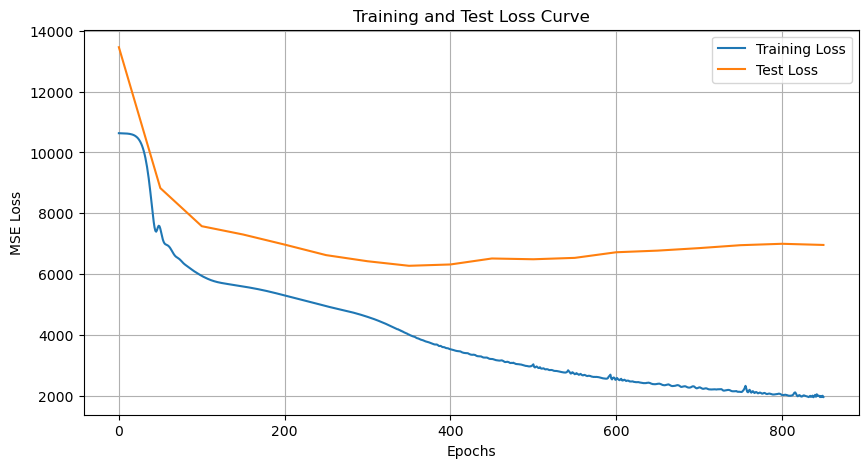

In [76]:
# 绘制损失曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(range(0, len(train_losses), 50), test_losses, label='Test Loss')
plt.title('Training and Test Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

## LinkPrediction (链路预测)

In [77]:
class HeteroGraphConvModel(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super(HeteroGraphConvModel, self).__init__()
        # 第一层异质图卷积
        self.conv1 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(in_feats, hid_feats)
            for rel in rel_names}, aggregate='sum')
        
        # 第二层异质图卷积
        self.conv2 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')

    def forward(self, graph, inputs):
        
        # edge_weights = {rel: graph.edges[rel].data.get('weight', None) for rel in graph.etypes}
        # 第一层卷积，传入边权重
        h = self.conv1(graph, inputs)
        # h = {k: F.sigmoid(v) for k, v in h.items()}
        h = {k: F.relu(v) for k, v in h.items()}
        # 第二层卷积，传入边权重
        h = self.conv2(graph, h)
        
        return h

### Space-Constrained Negative Sampling (空间约束的负采样)

In [84]:
proximity_set = set(zip(proximity_edges_df['src_id'], proximity_edges_df['dst_id']))  
out_flow_set = set(zip(out_flow_edges_df['src_id'], out_flow_edges_df['dst_id']))  
potential_set = proximity_set-out_flow_set
potential_edges = torch.tensor(list(potential_set))


def construct_negative_graph(graph, etype, k):
    utype, _, vtype = etype
    src, _ = graph.edges(etype=etype)

    # 存储有效的负样本  
    mask = torch.zeros(graph.num_nodes(vtype), dtype=torch.bool)
    mask[src] = True
    valid_neg_samples = potential_edges[mask[potential_edges[:, 0]]]

    # 随机打乱并选择前 k 个样本
    perm = torch.randperm(valid_neg_samples.size(0))[:len(src) * k]
    sampled_neg_samples = valid_neg_samples[perm]

    # 分割源和目标节点索引
    valid_neg_src = sampled_neg_samples[:, 0].to('cuda:0')
    valid_neg_dst = sampled_neg_samples[:, 1].to('cuda:0')

    # 创建负样本图
    neg_graph = dgl.heterograph({etype: (valid_neg_src, valid_neg_dst)},num_nodes_dict= {ntype: graph.num_nodes(ntype) for ntype in graph.ntypes}).to('cuda:0')
    
    g.nodes['spatial_unit'].data['feature'] = feature_matrix  
    g.nodes['spatial_unit'].data['delivery'] = delivery_tensor 
    g.nodes['spatial_unit'].data['pick_up'] = pick_tensor  
                            
    # 为每条边设置权重为0
    edge_weights = torch.zeros(len(valid_neg_src)).to('cuda:0')
    neg_graph.edata['weight'] = edge_weights  # 添加到图的边数据中

    # 创建负样本图
    return neg_graph

### LinkPredictor

In [79]:
class LinkPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        # 第一个隐藏层，从2*in_features到32
        self.hidden1 = nn.Linear(2 * in_features, 32)
        # 添加ReLU激活函数
        self.relu = nn.ReLU()
        # 第二个隐藏层，从32到16
        self.hidden2 = nn.Linear(32, 16)
        # 最后的全连接层，从16到1
        self.W = nn.Linear(16, out_classes)
        
    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        # 拼接节点特征
        combined_features = torch.cat([h_u, h_v], 1)
        # 通过第一个隐藏层并应用ReLU激活函数
        x = self.relu(self.hidden1(combined_features))
        # 通过第二个隐藏层
        x = self.relu(self.hidden2(x))
        # 最后通过输出层得到分数
        score = self.W(x)
        return {'score': score}
    

    def forward(self, graph, h,etype):
        with graph.local_scope():
            graph.ndata['h'] = h['spatial_unit']   # Assuming all nodes are of type 'spatial_unit'
#             print(f"graph.ndata['h'].shape = {graph.ndata['h'].shape}")
            graph.apply_edges(self.apply_edges, etype=etype)
            return graph.edata['score']

    
# 整合模型和链路预测
class LinkPredModel(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        self.gnn = HeteroGraphConvModel(in_features, hidden_features, out_features, rel_names)
        self.link_predictor = LinkPredictor(out_features,1)
    def forward(self, g, neg_g, x, etype, sample_etype):
        h = self.gnn(g, x)
        return self.link_predictor(g, h, etype), self.link_predictor(neg_g, h, etype)
    
    
class LinkPredModel_no_neg(nn.Module):   # 不负采样的版本
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        self.gnn = HeteroGraphConvModel(in_features, hidden_features, out_features, rel_names)
        self.link_predictor = LinkPredictor(out_features,1)
    def forward(self, g, x, etype, sample_etype):
        h = self.gnn(g, x)
        return self.link_predictor(g, h, etype)

### Define Loss

In [80]:
# 边预测
graph = graph.to('cuda:0')

unit_feats = graph.nodes['spatial_unit'].data['feature'].to('cuda:0')
edge_labels = graph.edges['out_flow'].data['weight'].to('cuda:0')
train_mask = graph.edges['out_flow'].data['train_mask'].to('cuda:0')
node_features = {'spatial_unit': graph.nodes['spatial_unit'].data['feature']}

def train_edge_prediction(edge_model, graph, features, train_mask ,edge_labels, epochs):
    optimizer = torch.optim.Adam(edge_model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()
    losses = []
    
    for epoch in range(epochs):
        edge_model.train()
        pred = edge_model(graph, features,'out_flow')
        pred = pred[('spatial_unit', 'out_flow', 'spatial_unit')] # !!!解决报错mask~tenser
        
        loss = loss_fn(pred[train_mask], edge_labels[train_mask])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    return losses


### Trainning

In [81]:
def calculate_metrics(pos_scores, neg_scores, pos_labels, device='cuda:0'):
    # Concatenate scores and true labels
    scores = torch.cat((pos_scores, neg_scores))
    true_labels = torch.cat((pos_labels, torch.zeros_like(neg_scores)))

    # Calculate Mean Squared Error (MSE)
    mse = F.mse_loss(scores, true_labels)

    # Calculate Mean Absolute Error (MAE)
    mae = F.l1_loss(scores, true_labels)

    # Calculate Mean Absolute Percentage Error (MAPE)
    def mape(y_true, y_pred):
        non_zero_mask = y_true != 0
        return torch.mean(torch.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

    mape_val = mape(true_labels, scores)

    # Calculate Symmetric Mean Absolute Percentage Error (SMAPE)
    def smape(y_true, y_pred):
        return 100 * 2 * torch.mean(torch.abs(y_pred - y_true) / (torch.abs(y_true) + torch.abs(y_pred)))

    smape_val = smape(true_labels, scores)

    return mse.item(), mae.item(), mape_val.item(), smape_val.item()

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).numpy()
    return roc_auc_score(labels, scores)

In [82]:
class ComputeLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse_loss = nn.MSELoss()
    
    def forward(self,  pos_score, neg_score,edge_labels):
        # Loss for positive scores: MSE between predicted scores and actual edge weights
        pos_loss = self.mse_loss(pos_score, edge_labels)
        
        # Loss for negative scores: encourage them to be zero
        neg_loss = torch.mean(neg_score ** 2)
        
        # Total loss: combine both losses
        return pos_loss + neg_loss
    
loss_fn = ComputeLoss()

In [83]:
# edge_labels = graph.edges['out_flow'].data['weight'].to('cuda:0')
edge_labels = torch.tensor(Flow_df['weight'].values, dtype=torch.float32).to('cuda:0')

in_features = 9
unit_feats = graph.nodes['spatial_unit'].data['feature'].to('cuda:0')
node_features = {'spatial_unit': unit_feats}

train_mask = graph.edges['out_flow'].data['train_mask'].to('cuda:0')
test_mask = graph.edges['out_flow'].data['test_mask'].to('cuda:0')

n_features = graph.ndata['feature'].shape[1]

etype = ('spatial_unit', 'out_flow', 'spatial_unit')
sample_etype = ('spatial_unit', 'proximity', 'spatial_unit')

model = LinkPredModel(in_features, hidden_features=256, out_features=64, rel_names=graph.etypes)
model = model.to('cuda:0')

opt = torch.optim.Adam(model.parameters(), lr=0.0005)

# 添加早停参数
patience = 10  # 你可以根据需要调整这个值
patience_counter = 0  # 耐心计数器
best_loss = float('inf')  # 初始化最佳损失为无穷大

# 保存训练和测试的损失
train_losses = []
test_losses = []

for epoch in range(50000):
    model.train()
    negative_graph = construct_negative_graph(graph, k=1, etype=etype)
    pos_score, neg_score = model(graph, negative_graph, node_features, etype, sample_etype)

    loss = loss_fn(pos_score[etype][train_mask][:, 0], neg_score[train_mask][:, 0], edge_labels[train_mask])

    opt.zero_grad()
    loss.backward()
    opt.step()

    train_losses.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

        model.eval()
        pos_score, neg_score = model(graph, negative_graph, node_features, etype, sample_etype)
        pos_score_test = pos_score[etype][test_mask][:, 0]
        neg_score_test = neg_score[test_mask][:, 0]
        edge_labels_test = edge_labels[test_mask]

        mse, mae, mape_val, smape_val = calculate_metrics(pos_score_test, neg_score_test, edge_labels_test, device='cuda:0')
        print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape_val}, SMAPE: {smape_val}")

        test_losses.append(mse)

        # 更新最佳损失和早停计数器
        if mse < best_loss:
            best_loss = mse
            patience_counter = 0  # 重置耐心计数器
            print("New best MSE observed, resetting patience counter.")
        else:
            patience_counter += 1
            print(f"No improvement observed. Incrementing patience counter to {patience_counter}")

        # 检查是否达到早停条件
        if patience_counter >= patience or mse < 20:
            print("Early stopping triggered.")
            break

Epoch 0, Loss: 428.46075439453125
MSE: 205.35763549804688, MAE: 7.784411430358887, MAPE: 99.43145751953125, SMAPE: 198.86947631835938
New best MSE observed, resetting patience counter.
Epoch 500, Loss: 93.2021255493164
MSE: 52.03814697265625, MAE: 4.0876336097717285, MAPE: 43.065067291259766, SMAPE: 121.11231994628906
New best MSE observed, resetting patience counter.
Epoch 1000, Loss: 57.94618225097656
MSE: 48.745018005371094, MAE: 3.7737276554107666, MAPE: 42.123878479003906, SMAPE: 120.86518859863281
New best MSE observed, resetting patience counter.
Epoch 1500, Loss: 44.79161834716797
MSE: 49.18174362182617, MAE: 3.7148821353912354, MAPE: 43.435829162597656, SMAPE: 121.38905334472656
No improvement observed. Incrementing patience counter to 1
Epoch 2000, Loss: 37.599666595458984
MSE: 48.306636810302734, MAE: 3.6598269939422607, MAPE: 42.804359436035156, SMAPE: 122.09561157226562
New best MSE observed, resetting patience counter.
Epoch 2500, Loss: 32.98474884033203
MSE: 49.422588348

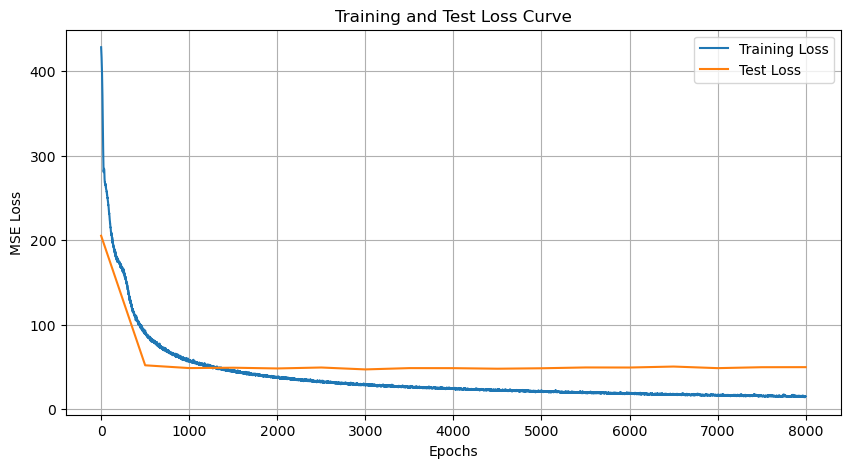

In [85]:
# 绘制训练和测试损失曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(range(0, len(train_losses), 500), test_losses, label='Test Loss')
plt.title('Training and Test Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
# Calculate metrics for test data
with torch.no_grad():
    model.eval()
    pos_score, neg_score = model(graph, negative_graph, node_features, etype, sample_etype)
    pos_score_test = pos_score[etype][test_mask][:,0]
    neg_score_test = neg_score[test_mask][:,0]
    edge_labels_test = edge_labels[test_mask]
    
mse, mae, mape_val, smape_val = calculate_metrics(pos_score_test, neg_score_test, edge_labels_test, device='cuda:0')
print(f"MSE: {mse}, MAE: {mae}, MAPE: {mape_val}, SMAPE: {smape_val}")

MSE: 19.525968551635742, MAE: 2.200423240661621, MAPE: 46.26103210449219, SMAPE: 122.88886260986328


In [61]:




with torch.no_grad():
    model.eval()
    etype = ('spatial_unit', 'out_flow', 'spatial_unit')
    # sample_etype = ('spatial_unit', 'promiximity', 'spatial_unit')
    sample_etype = ('spatial_unit', 'out_flow', 'spatial_unit')

    pos_score, neg_score = model(graph, negative_graph, node_features, etype,sample_etype)
    pos_score = pos_score[etype].to('cpu')
    neg_score = neg_score.to('cpu')
    print("AUC", compute_auc(pos_score, neg_score))

AUC 0.9641650628244216
